In [4]:
import networkx as nx
import time
import json
import matplotlib.pyplot as plt

# SAE 2.02 Exploration Algorithmique dʼun problème

- Alexandre RAVIART
- Daniel MOREIRA

# 1 Echauffement

Afin de convertir le format de données json au graphe, la conversion fut en 3 étapes : json -> dict() -> Graph(). Nous pourrions directement convertir du json à un graphe networkX, mais la conversion en dictionnaire permet de traiter les données hors cast et le temps d'execution étant faible (3s en moyenne pour la conversion en dico avec le set de donnée entier), on peut se le permettre.

Le format adopté :
{Nom_du_Film : {cast : [liste_des_acteurs]}, {director : [liste_des_directeurs]}, {producers : [liste_des_producteurs]}, {companies: [liste_des_companies]}, {year: [Date_de_sorti]}}

## json -> dict()

In [ ]:

def convert_txt_to_dict(nom_fichier):
    """charge un fichier de lignes json en dictionnaire 

    Args:
        nom_fichier (str): nom du fichier txt contenant les lignes json

    Returns:
        dict: le dictionnaire avec le contenus du fichier
    """
    with open(nom_fichier, encoding='utf-8') as fichier_open:
        lignes = fichier_open.readlines()
        dico = {}
        for json_data in lignes:
            # gestion des symboles [[]] |
            Data = json.loads(json_data)
            titre = Data["title"].replace("[[", "").replace("]]", "")
            cast = [personne.split("|")[0].split("(")[0].replace("[[", "").replace("]]", "") if "|" in personne else personne.replace("[[", "").replace("]]", "") for personne in Data.get("cast", [])]
            directeur = [director.replace("[[", "").replace("]]", "") for director in Data.get("directors", [])]
            producteur = [prod.replace("[[", "").replace("]]", "") for prod in Data.get("producers", [])]
            companies = [comp.replace("[[", "").replace("]]", "") for comp in Data.get("companies", [])]
            annee_sorti = Data.get("year", [])
            
            dico[titre] = {
                "cast": cast,
                "director": directeur,
                "producers": producteur,
                "companies": companies,
                "year": annee_sorti
            }
    return dico

dictionnaire_fichier = convert_txt_to_dict("medium_data.txt")

## dict() -> Graph()

In [53]:


def creation_graphe(dico):
    """créez un graph networkx à partir du dictionnaire issue convert_txt_to_dict().

    Args:
        nom_dico (dict): nom du dictionnaire au format {Nom_du_Film : {cast : [liste_des_acteurs]}, {director : [liste_des_directeurs]}, {producers : [liste_des_producteurs]}, {companies: [liste_des_companies]}, {year: [Date_de_sorti]}}.

    Returns:
        networkx.classes.digraph.DiGraph: Graph networkX représentant des relations entre acteurs (cast).
    """
    g = nx.DiGraph()
    acteurs_vue = set()
    for film in dico.values():
        for i in range(len(film["cast"])):
            acteur1 = film["cast"][i]
            if acteur1 not in acteurs_vue: 
                g.add_node(acteur1)
                acteurs_vue.add(acteur1)
            for b in range(i+1, len(film["cast"])): # i+1 pour éviter de rajouter relations à lui-même
                acteur2 = film["cast"][b]
                if acteur2 not in acteurs_vue:
                    g.add_node(acteur2)
                    acteurs_vue.add(acteur2)
                # on ajoute l'arête dans tout les cas
                g.add_edge(acteur1, acteur2, length=10)
    return g
graphe = creation_graphe(dictionnaire_fichier)

Pour le dessin, une petite proportion de données doit être utilisé car l'utilisation de draw de networkX ou des fonctions d'affichage de plt prennent beaucoup de temps.
L'affichage des étiquettes (with_labels=False), la taille des noeuds, le type de layout etc.. impacte la performance, nous avons décider de laisser par défaut.


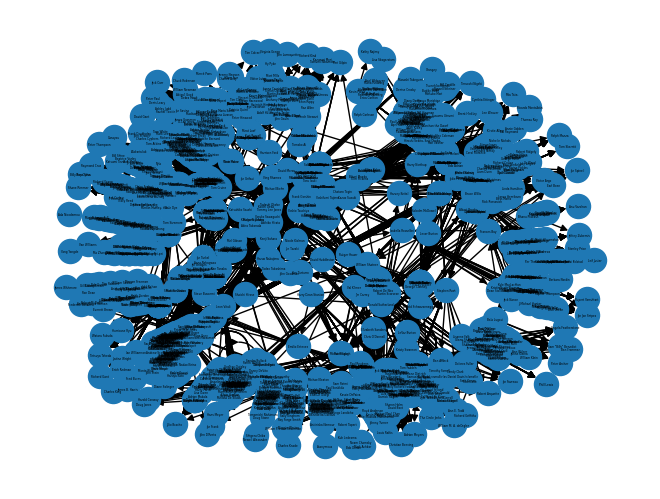

In [63]:
# le dessin peut prendre beaucoup de temps, d'autant plus quand le graph est grand
def dessine_graph(G):
    nx.draw(G, with_labels=True, font_size= 2)
dessine_graph(graphe)

# 2. Collaborateurs en commun

In [37]:
def colab_en_commun(G, u, v):
    """
    Retourne l'ensemble des collaborateurs communs entre deux acteurs du graphe G.

    Args:
        G (networkx.classes.digraph.DiGraph): Le graphe dans lequel rechercher les collaborateurs communs.
        u (node): un acteur.
        v (node): un  autre acteur.

    Returns:
        set: Un ensemble des collaborateurs communs entre u et v.

    """
    collab_commun = set()
    if u not in G.nodes or v not in G.nodes:
        return None
    # on regarde les collaborateurs directes de u et v
    adjU = G.adj[u]
    adjV= G.adj[v] 
    for i in adjU:# O(d(u))
        for v in adjV:# O(d(v))
            # pour chaque collaborateur direct en commun, ont ajoute à l'ensemble si celui-ci n'est pas déjà ajoutée,
            if i == v and i not in colab_en_commun: # O(1)
                collab_commun.add(i)# i ou v cela revient au même car i==v
    return collab_commun



## .a
Notion : l'existence d'un acteur/noeud avec un degré de 1 pour les deux acteurs donnés indique qu'il existe un nœud intermédiaire qui est connecté directement à la fois à l'acteur 1 et à l'acteur 2 ou autrement dit qu'un même noeud appartient au voisinage de 2 noeuds différents.


$$\text{CollabComm}(G, u, v) = \{ i \mid i \in V(u) \cap V(v) \}$$

- i : ensemble des noeuds qui satisfait la condition
- V(u) et V(v) respecitivement les voisins de u et v


## .b
La complexité dépend de la taille de liste d'ajacence de u et v, elle est de O(d(u) * O(d(v)) en l'occurence car l'on vérifie les collaborateurs en commun en vérifiant toute la liste d'adjacence.

# 3. Collaborateurs proches 

In [22]:
# la fonction donnée :

def collaborateurs_proches(G,u,k): # parcours en largeur
    """Fonction renvoyant l'ensemble des acteurs à distance au plus k de l'acteur u dans le graphe G. La fonction renvoie None si u est absent du graphe.
    
    Parametres:
        G: le graphe
        u: le sommet de départ
        k: la distance depuis u
    """
    if u not in G.nodes: # cout linéaire O(1) pour la vérification de l'existance d'un noeud dans un graphe et création des variables
        print(u,"est un illustre inconnu")
        return None
    collaborateurs = set()
    collaborateurs.add(u)
    print(collaborateurs)
    for i in range(k): # on explore les sucesseurs des successeurs et ainsi de suite à un degrès k maximum du noeud u 
        collaborateurs_directs = set() # cout quadratique, proportionelle au  produit du degré moyen des acteurs à la celui de la distance K soit  O(D*K) pour les 2 boucles
        for c in collaborateurs:
            for voisin in G.adj[c]:
                if voisin not in collaborateurs:
                    collaborateurs_directs.add(voisin)
        collaborateurs = collaborateurs.union(collaborateurs_directs) # le cout de l'union est au plus proportionelle à la taille des ensemble unis qui est le cout des acteurs ajoutées une fois. 0(D*K)
    return collaborateurs

## a. 
L'algorithme au coeur de ce graphe est le BFS (Breadth-First Search), en effet l'algorithme va explorer tous les voisins directs avant de passer aux voisins des voisins sucessivement jusqu'à un degré k, ici il va le faire de façon itérative sans utiliser de file. On ne va pas suivre un chemin le plus loin possible puis retourner a l'ancêtre qui possède des chemins encore non visités (DFS).

- voir commentaires python

on à donc O(D\*K)+O(D\*K) = 2(O(D\*K)) que l'on peut simplifier à O(D*K) 
En supposant un nombre moyen de degré des noeuds.

## b. 
Afin de déterminer si un acteur u se trouve à une distance k d'un acteur v, la fonction collaborateur en commun s'avère judicieuse, en effet elle nous indique les relations directe et indirectes entre acteurs, nous avons juste à regarder si dans l'ensemble des collaborateurs de u à la distance k, il existe l'acteur v.

In [6]:
def est_a_distance_k(G, u, v, k):
    """
    Vérifie si deux acteurs u et v sont à une distance strictement inférieure a k dans le graphe.

    Args:
        G (networkx.classes.digraph.DiGraph): Le graphe représentant la relations entre des acteurs.
        u (node): L'acteur de départ.
        v (node): L'acteur cible.
        k (int): La distance à ne pas dépasser.

    Returns:
        bool: True si u et v sont à une distance strictement inférieure à k, False sinon.
    """
    if u == v:
        return True
    if k == 0:
        return False
    collaborateurs = collaborateurs_proches(G, u, k)
    return v in collaborateurs 


## c. d.

Nous avons vu la manière de determiné si un acteur était dans le rayon d'un autre (réciproquement ducoup), pour determiné la k minimal, la fonction collaborateurs_proches(G,u,k) est une fois de plus pertinente. Nous avons juste à initialiser la distance k à 1, et l'incrémenté jusqu'à avoir l'acteur recherché dans l'ensemble des collaborateur présent dans ce rayon k, que l'on retournera.

In [ ]:
def distance_acteurs_iterative(G,u,v):
    # initialisation des variables O(1)
    distance = 1 # on initialise à un car ça n'a pas de sens un voisinage a 0
    trouve = False
    # vérification d'appartenance de noeud dans un graph O(1)
    if u not in G.nodes or v not in G.nodes:
        return None
    deja_vu = []
    
    collabs = collaborateurs_proches(G,u,distance)# O(D*K)
    while distance <= 6 and not trouve: # N itération O(D*K)
        for acteur in collabs:
            if acteur not in deja_vu:
                if acteur == v:
                    trouve = True
                deja_vu.append(acteur)
        distance += 1
        collabs = collaborateurs_proches(G,u,distance)
    return distance-1

La fonction calculer_centralite_acteur, permet d'obtenir le centralite d'un acteur dans le graphe.

Nous utilisons la fonction closeness_centrality de networkx, qui permet d'optenir la centralité de l'acteur en utilisant le parcour en largeur.

Dans le meilleur des cas (v voisin de u) on à O(D*K) et dans le pire on à 6O(D*K) qu'on peut simplifier à O(D*K).

## fonctions utiles pour les distances

In [17]:
def distance(G, u, v): # bfs distance
    # plus performante et approprié pour connaitre la distance entre deux acteurs car elle donne le plus court chemin
    # performance (O(n*m))
    """
    Calcule la distance entre deux acteurs donnés dans un graphe en utilisant la recherche en largeur (BFS).

    Args:
        G (networkx.classes.digraph.DiGraph): Le graphe des acteurs
        u: L'acteur 1
        v: L'acteur 2

    Returns:
        int: La distance entre les deux acteurs, si l'itinéraire n'existe pas (acteur inexistant) retourne None
    """
    if u not in G.nodes or v not in G.nodes:
        return None
    visite = []  # liste des noeuds déjà visités
    file = [[u]]  # queue des chemins à explorer
    while file:
        chemin = file.pop(0)  #premier chemin de la file d'attente
        noeud_courant = chemin[-1]  #dernier noeud du chemin en cours
        if noeud_courant not in visite:
            voisins = G[noeud_courant] 
            for voisin in voisins:
                nouveau_chemin = list(chemin)  # copie du chemin en cours
                nouveau_chemin.append(voisin)  # ajoute le voisin au chemin
                file.append(nouveau_chemin)  # ajoute le nouveau chemin à la file d'attente
                if voisin == v:
                    return len(nouveau_chemin)-1
                if len(file) > len(G.nodes):
                    return 0  # dans le cas ou il n'y'a pas de relations entre les 2 acteurs, on ne retourne pas None pour la condition distance > val de la fonction eloignement_max(G)
        visite.append(noeud_courant)  # le noeud courant est compté comme visité


In [1]:

def liste_acteur_a_distance_k(G, k):
    """
    Renvoie un dictionnaire contenant les acteurs à une distance strictement k dans le graphe G.
    Args:
        G (networkx.classes.digraph.DiGraph): Le graphe représentants les acteurs.
        k (int): La distance.
    Returns:
        dict: Un dictionnaire ayant l'acteur comme clé qui à comme valeur l'ensembles de ses collaborateurs ou collaborateurs de collaborateurs à une distance k.
    """
    dico_acteur = dict()
    for acteur in G.nodes:
        if acteur not in dico_acteur:
            a = collaborateurs_proches(G, acteur, k)
            b = collaborateurs_proches(G, acteur, k-1)
            if a != b:
                dico_acteur[acteur] = a - b
    return dico_acteur

In [ ]:
def distance_dijkstra(G, u, v):
  # plus efficace que toutes les autres, utilisation de l'algo de djikstra
  # performance  O((n + m) log n)
  distance = nx.shortest_path_length(G, u, v)
  return distance

autres pistes : algo de floyd warshall, algo a*...

4. 
## a. Notion de centralité

$c(G,s) = \min{c(G,v)}, v∈V(G)$

Le calcul effectué dans la fonction centralite_acteur se base sur la notion de "proximité" pour évaluer la centralité d'un acteur. Cette mesure de centralité est utilisée car simplement compter le nombre de connexions directes d'un acteur ne suffirait pas à refléter son importance au sein du graphe. En effet, il est important de considérer la façon dont un acteur est relié à l'ensemble des autres acteurs dans le graphe (tenir compte de la structure de G).

Le calcul consiste à prendre en compte la distance des chemins les plus courts entre un acteur donné et tous les autres acteurs du graphe. On additionne ces distances pour obtenir une mesure de proximité. Ensuite, on divise ce résultat par 1 pour normaliser la mesure. Cette approche permet de quantifier la proximité globale d'un acteur par rapport à l'ensemble des autres acteurs du graphe.

Calcul de centralité de proximité :
Pour cela, nous utiliserons closeness_centrality de NetworkX, une version algorithmique et celle d'intermédiarité, premièrement, la formule utilisée sera la suivante :

$c(v) = \frac{{1}}{{\sum_{u \neq v} \text{{distance la plus courte de }} u \text{{ à }} v}}$



## avec l'utilisation de closeness centrality

## a.



In [48]:
def calculer_centralite_acteur_proximitenx(Gc, acteur):
    return nx.closeness_centrality(Gc, u=acteur)
calculer_centralite_acteur_proximitenx(graphe, "Mercè Pons")


0.006864988558352402

La fonction trouver_acteur_plus_central permet d'obtenir l'acteur qui est le plus au centre du Graphe.
Pour cela nous utilisons encore la fonction closeness_centrality de networkx, pour avoir la centralité de toute les acteurs du graphe, puis nous obtenons le maximum.

## b.

In [30]:
def trouver_acteur_plus_central_proximitenx(G):
    noeud_proximite = nx.closeness_centrality(G)
    noeud_central = max(noeud_proximite, key=noeud_proximite.get)
    return noeud_central

# trouver_acteur_plus_central_proximitenx(graphe)

In [44]:
## de façon algorithmique

def centralite_acteur(G, u):
  somme_court_chemins = 0
  deja_vus = set()
  for acteur in G.nodes:
      if acteur not in deja_vus:
        dis = distance(G, u, acteur)
        if dis is not None:
          somme_court_chemins+=distance(G, u, acteur)
        deja_vus.add(acteur)
  if somme_court_chemins != 0:
    return 1/somme_court_chemins 
  return 0

# print(centralite_acteur(graphe, "Mercè Pons"))
    

In [ ]:
def acteur_au_centre(G):
    centralites = {}
    for acteur in G.nodes:
        centralite = centralite_acteur(G, acteur)
        centralites[acteur] = centralite
    acteur_centre = max(centralites, key=centralites.get)
    return acteur_centre
  
  
acteur_au_centre(graphe)

# avec le calcul de d'intermédiarité

$\text{centralité d'intermédiarité}(acteur) = \frac{\sum_{s \neq v \neq t} \frac{\sigma_{st}(v)}{\sigma_{st}}}{(n-1)(n-2)}$


In [2]:


def calculer_centralite_acteur_inter(G, acteur):
    return nx.betweenness_centrality(G)[acteur]

print(calculer_centralite_acteur_inter(graphe, "Paul Reubens"))
def trouver_acteur_central_inter(G):
    centralite_max = 0
    acteur_central = None
    for acteur in G.nodes:
        centralite = calculer_centralite_acteur_inter(G, acteur)
        if centralite > centralite_max:
            centralite_max = centralite
            acteur_central = acteur
    return acteur_central

# print(acteur_au_centre)
acteur_central = trouver_acteur_central_inter(graphe)


<class 'NameError'>: name 'graphe' is not defined

In [ ]:
# relation proximite et inter ? on pourrait suposser que si un acteur est proche de tout les autres il aurait tendance à se trouver sur les plus cours chemin
def centralite_comparer(G):
  dico_comparaison = dict()
  for acteur in G.nodes:
    centraliteProxi = calculer_centralite_acteur_proximitenx(G, acteur)
    centraliteInter = calculer_centralite_acteur_inter(G,acteur)
    dico_comparaison[acteur] = {"proximité" : centraliteProxi, "intermédiarité" : centraliteInter }
  return dico_comparaison

centralite_comparer(graphe)
  

# 5 Eloignement

## avec nx.shortest_path_length (qui implémente l'algo de Djikstra)

Nous utiliserons combinations de la bibliothèque itertools afin de générer tout les couples d'acteurs uniques.
Entre toute paire dʼacteurs/actrices la chaine de relations sociales s'est avérée pour nous supérieur à 6 (10) sur une portion très petite d'un set de donnée (100 lignes). C'est entre Kevin Bacon et tout les autres noeuds qu'il faut vérifier la règle des six degrès de séparation.

## version avec tout les couples possibles

In [59]:
from itertools import combinations

def distance_maximale_entre_acteurs_networkx(G):
    distances = []
    for acteur1, acteur2 in combinations(G.nodes(), 2):
        try:
            distance = nx.shortest_path_length(G, acteur1, acteur2)
            distances.append(distance)
        except nx.NetworkXNoPath:
            distances.append(0)  # 0 pour représenter une distance qui existe pas
    distance_max = max(distances)
    return distance_max

print(distance_maximale_entre_acteurs_networkx(graphe))

10


## version avec un acteur et tout les autres couples

C'est avec cette fonction que la distance max doit etre inférieur ou égale à 6 si Kevin Bacon est passé en argument.

In [68]:
def dis_max_acteur_lesautres(G, acteur):
    distances = []
    for autre_acteur in G.nodes():
        if autre_acteur != acteur:
            try:
                distance = nx.shortest_path_length(G, acteur, autre_acteur)
                distances.append(distance)
            except nx.NetworkXNoPath:
                distances.append(0)  # 0 pour représenter une distance qui n'existe pas
    distance_max = max(distances)
    return distance_max
  
print(dis_max_acteur_lesautres(graphe, "Arnold Schwarzenegger"))

NodeNotFound: Either source Kevin Bacon or target Núria Espert is not in G

## avec les distance calculer en BFS

In [56]:
def distance_maximale_entre_acteurs(G):
    # moins performant que la version networkx
    max_distance = 0
    
    for actor1, actor2 in combinations(G.nodes, 2):
        dis = distance(G, actor1, actor2)  # Utilise la fonction distance définie précédemment
        if dis is not None and dis > max_distance: # None si il 
            max_distance = dis

    return max_distance
    return max_distance
print(distance_maximale_entre_acteurs(graphe))

KeyboardInterrupt: 

# Bonus a.

# nécessite d'avoir créez le graphe en entier avant

{'Arnold Schwarzenegger'}


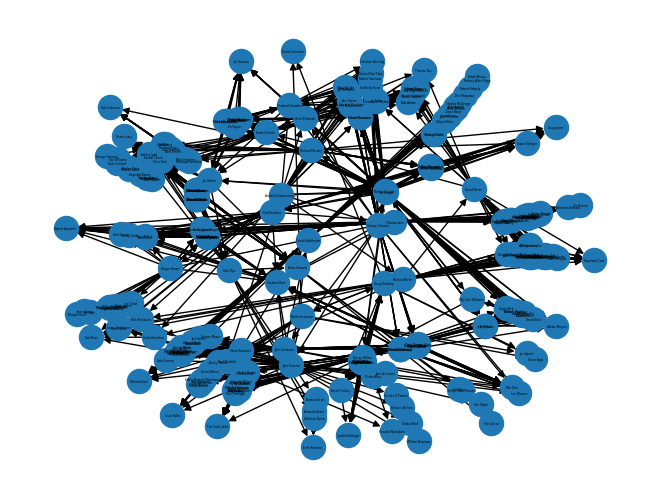

In [64]:
def creer_sous_graphe(G, u, k):
    """
    Crée un sous graphe à partir d'un acteur u jusqu'à un degré k de u

    Args:
        G (networkx.classes.digraph.DiGraph): Le graphe des acteurs
        u: L'acteur de départ
        k (int): Le degrée max par rapport à l'acteur u

    Returns:
        networkx.classes.digraph.DiGraph: Le sous-graphe contenant les noeuds à une distance au plus k de u

    """
    collabs_proches = collaborateurs_proches(G, u, k)
    subgraph = G.subgraph(collabs_proches).copy()
    return subgraph

sous_graphe = creer_sous_graphe(graphe, "Arnold Schwarzenegger", 4)
nx.draw(sous_graphe, with_labels=True, font_size=2)

In [61]:
def acteur_central_sous_graphe(G, u, k):
  sous_graphe = creer_sous_graphe(G, u, k)
  return trouver_acteur_plus_central_proximitenx(sous_graphe)

acteur_central_sous_graphe(graphe, "Arnold Schwarzenegger", 3)

{'Arnold Schwarzenegger'}


'Robert Arquette'